<a href="https://colab.research.google.com/github/omer358/ml-acamey/blob/master/ML_Academy_Classical_Machine_Learning_Models_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [7]:
!cd sample_data

In [8]:
!ls

sample_data


In [9]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [4]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as pandas dataframe and display first 5 rows
#year: 2016 for all data points
#month: number for month of the year
#day: number for day of the year
#week: day of the week as a character string
#temp_2: max temperature 2 days prior
#temp_1: max temperature 1 day prior
#average: historical average max temperature
#actual: max temperature measurement
#friend: your friend’s prediction, a random number between 20 below the average and 20 above the average
features = pd.read_csv('temps.csv')
features.head(10)

FileNotFoundError: ignored

In [ ]:
print('The shape of our features is:', features.shape)

The shape of our features is: (348, 12)


## One-Hot Encoding

One hot encoding takes this:

| week |
|------|
| Mon  |
| Tue  |
| Wed  |
| Thu  |
| Fri  |

and converts it into:

| Mon | Tue | Wed | Thu | Fri |
|-----|-----|-----|-----|-----|
| 1   | 0   | 0   | 0   | 0   |
| 0   | 1   | 0   | 0   | 0   |
| 0   | 0   | 1   | 0   | 0   |
| 0   | 0   | 0   | 1   | 0   |
| 0   | 0   | 0   | 0   | 1   |

In [ ]:
# One-hot encode categorical features
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


In [ ]:
print('Shape of features after one-hot encoding:', features.shape)

Shape of features after one-hot encoding: (348, 18)


## Features and Labels

In [ ]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['actual'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('actual', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)


In [ ]:
len(labels)

348

In [ ]:
len(features)

348

## Training and Testing Sets

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 17)
Training Labels Shape: (261,)
Testing Features Shape: (87, 17)
Testing Labels Shape: (87,)


## Establish Baseline

In [ ]:
# Before we can make and evaluate predictions, we need to establish a baseline, a sensible measure that we hope to beat with our model.
# our baseline is the error we would get if we simply predicted the average max temperature for all days.
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('average')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'degrees.')

Average baseline error:  5.06 degrees.


## Training the Forest

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

We can create models with different hyperparameters to try and boost performance. The only way to find the best ones
are to try a few and evaluate them! 

In [ ]:
rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
                               min_samples_split = 2, min_samples_leaf = 1)

## Make Predictions on Test Data

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 3.87 degrees.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.93 %.


## Visualizing a Single Decision Tree

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

![Decision Tree](tree.png)

In [ ]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 13


Smaller tree for visualization.

In [ ]:
# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png')

![Small Decision Tree](small_tree.PNG)

### Annotated Version of Tree

![Annotated Decision Tree](small_tree_annotated.PNG)

## Variable Importances

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.66
Variable: average              Importance: 0.15
Variable: forecast_noaa        Importance: 0.05
Variable: forecast_acc         Importance: 0.03
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: forecast_under       Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


### Two Most Important Features

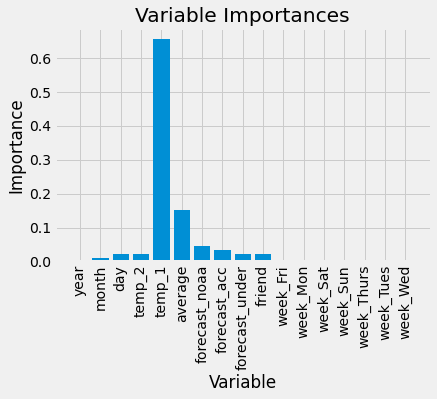

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.92 degrees.
Accuracy: 93.76 %.
